In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pdb
import torch
from torch import nn
import torch.utils.data as data
from tqdm import tqdm

In [5]:
#With heavy help from https://github.com/benmoseley/harmonic-oscillator-pinn-workshop/blob/main/PINN_intro_workshop.ipynb

In [4]:
class FeedForward(nn.Module):
    #So bog basic it should tap for black mana
    #DT That one's for you
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(4, 30)
        self.linear2 = nn.Linear(30,30)
        self.linear3 = nn.Linear(30,30)
        self.linear4 = nn.Linear(30,4)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)
        x = torch.clamp(x, -1e6, 1e6)
        return x

In [5]:
g = 9.81
def derivatives(t, state):
    m1, m2, L1, L2 = 1,1,1,1
    if torch.nan in state:
        raise ValueError()
    if torch.inf in state or -torch.inf in state:
        raise ValueError()
    theta1, theta2, z1, z2 = torch.split(state, 1, dim=1)
    # print(theta1, theta2, z1, z2)
    delta = theta2 - theta1
    if torch.nan in delta:
        raise ValueError()
    if torch.inf in delta or -torch.inf in delta:
        raise ValueError()

    denominator1 = (m1 + m2) * L1 - m2 * L1 * np.cos(delta) ** 2
    denominator2 = (L2 / L1) * denominator1

    dtheta1_dt = z1
    dz1_dt = (
        (m2 * L1 * z1 ** 2 * np.sin(delta) * np.cos(delta)
         + m2 * g * np.sin(theta2) * np.cos(delta)
         + m2 * L2 * z2 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta1))
        / denominator1
    )
    if torch.nan in dz1_dt:
        raise ValueError()
    dtheta2_dt = z2
    dz2_dt = (
        (-m2 * L2 * z2 ** 2 * np.sin(delta) * np.cos(delta)
         + (m1 + m2) * g * np.sin(theta1) * np.cos(delta)
         - (m1 + m2) * L1 * z1 ** 2 * np.sin(delta)
         - (m1 + m2) * g * np.sin(theta2))
        / denominator2
    )

    return np.column_stack([dtheta1_dt, dz1_dt, dtheta2_dt, dz2_dt])

In [6]:
def rk4_derivs(state, f, h):
    t = 0
    k1 = f(t, state)
    # print(state.shape)
    # print(k1.shape)
    k2 = f(t + h*0.5, state + k1*h*0.5)
    k3 = f(t + h*0.5, state + k2*h*0.5)
    k4 = f(t + h, state + k3*h)
    return (k1 + 2*k2 + 2*k3 + k4) / 6

class PINNLoss(nn.Module):
    def __init__(self, tstep, lamb=.5):
        super().__init__()
        self.tstep = tstep
        self.lamb = lamb
        self.data_crit = nn.MSELoss()
        self.physics_crit = nn.MSELoss()

    def forward(self, y_pred, y_true, input_data):
        data_loss = self.data_crit(y_pred, y_true)
        
        empirical_derivs = (y_pred - input_data) / self.tstep
        true_derivs = torch.tensor(rk4_derivs(input_data, derivatives, self.tstep))
        physics_loss = self.physics_crit(empirical_derivs, true_derivs)

        return self.lamb * data_loss + (1-self.lamb) * physics_loss

In [7]:
timestep = 1/200
pinn = FeedForward()
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
lamb = 0.5 #Test different values for this?
criterion = PINNLoss(timestep, lamb=lamb)
num_epochs = 50000
val_every = 2500
save_every = 10000
train_losses = []
val_losses = []
epoch_size = int(2**15)
val_set_size = int(2**13)
for i in tqdm(range(num_epochs)):
    #generate some new training data
    #Now with all-equal lengths and masses
    X = np.empty((epoch_size,4))
    X[:,:2] = np.random.uniform(-np.pi, np.pi, size=(epoch_size,2))
    X[:,2:] = np.random.normal(size=(epoch_size,2))
    X_batch = torch.tensor(X)
    y_batch = X_batch+rk4_derivs(X_batch, derivatives, timestep)*timestep

    train_losses_local = []
    # for X_batch, y_batch in train_loader:
    # if torch.inf in X_batch or -torch.inf in y_batch:
    #     print('Found inf in data!')
    #     pdb.set_trace()
    X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
    optimizer.zero_grad()
    y_pred = pinn(X_batch)
    # empirical_derivs = (output_vector - input_data) / timestep
    # physics_loss = (derivs - derivatives(input_data))**2 #Divide by N elns?
    # data_loss = lamb*(true_output - output_vector)**2
    # loss = physics_loss + data_loss
    loss = criterion(y_pred, y_batch, X_batch)
    loss.backward()
    train_losses_local.append(loss.item())
    optimizer.step()
    train_losses.append(np.mean(train_losses_local))

    if (i+1) % val_every == 0:
        X = np.empty((val_set_size,4))
        X[:,:2] = np.random.uniform(-np.pi, np.pi, size=(val_set_size,2))
        X[:,2:] = np.random.normal(size=(val_set_size,2))
        X_batch = torch.tensor(X)
        y_batch = X_batch+rk4_derivs(X_batch, derivatives, timestep)*timestep
        pinn.eval()
        val_losses_local = []
        X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
        optimizer.zero_grad()
        y_pred = pinn(X_batch)
        loss = criterion(y_pred, y_batch, X_batch)
        val_losses_local.append(loss.item())
        val_losses.append(np.mean(val_losses_local))
        pinn.train()
    #pinn() is supposed to approximate, as a function, the next timestep given the state of a system, and training data with consistent timesteps
    if not (i+1) % save_every:
        with open(f'../models/shuffled_4dout_online_{i+1}_epochs_statedict.torch', 'wb') as file:
            torch.save(pinn.state_dict(), file)

  0%|          | 58/50000 [00:03<49:31, 16.81it/s]


KeyboardInterrupt: 

0.362272173166275


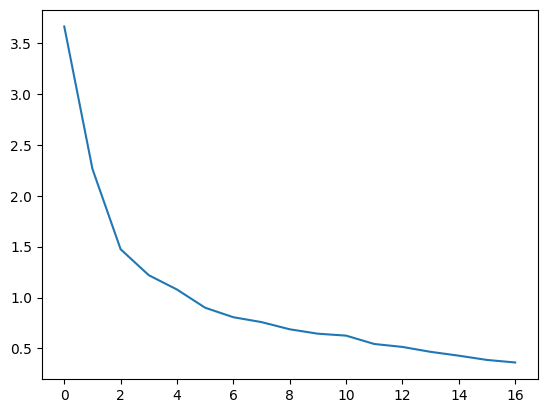

In [206]:
plt.plot(val_losses[3:])
print(val_losses[-1])

In [209]:
num_epochs = 50000
save_every = 10000
for i in tqdm(range(num_epochs)):
    #generate some new training data
    #Now with all-equal lengths and masses
    X = np.empty((epoch_size,4))
    X[:,:2] = np.random.uniform(-np.pi, np.pi, size=(epoch_size,2))
    X[:,2:] = np.random.normal(size=(epoch_size,2))
    X_batch = torch.tensor(X)
    y_batch = X_batch+rk4_derivs(X_batch, derivatives, timestep)*timestep

    train_losses_local = []
    X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
    optimizer.zero_grad()
    y_pred = pinn(X_batch)

    loss = criterion(y_pred, y_batch, X_batch)
    loss.backward()
    train_losses_local.append(loss.item())
    optimizer.step()
    train_losses.append(np.mean(train_losses_local))

    if (i+1) % val_every == 0:
        X = np.empty((val_set_size,4))
        X[:,:2] = np.random.uniform(-np.pi, np.pi, size=(val_set_size,2))
        X[:,2:] = np.random.normal(size=(val_set_size,2))
        X_batch = torch.tensor(X)
        y_batch = X_batch+rk4_derivs(X_batch, derivatives, timestep)*timestep
        pinn.eval()
        val_losses_local = []
        X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
        optimizer.zero_grad()
        y_pred = pinn(X_batch)
        loss = criterion(y_pred, y_batch, X_batch)
        val_losses_local.append(loss.item())
        val_losses.append(np.mean(val_losses_local))
        pinn.train()
    #pinn() is supposed to approximate, as a function, the next timestep given the state of a system, and training data with consistent timesteps
    if not (i+1) % save_every:
        with open(f'shuffled_4dout_online_{i+50001}_epochs_statedict.torch', 'wb') as file: #TODO TODO CHANGE THIS!
            torch.save(pinn.state_dict(), file)

100%|██████████| 50000/50000 [1:41:32<00:00,  8.21it/s]     


0.2468709945678711


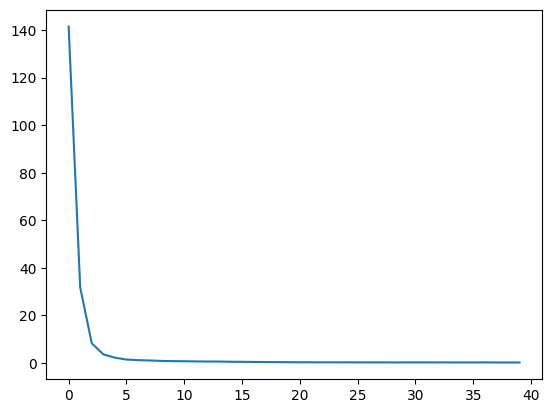

In [211]:
plt.plot(val_losses)
print(val_losses[-1])

In [9]:
timestep = 1/200
lamb = 0.5 #Test different values for this?
criterion = PINNLoss(timestep, lamb=lamb)
val_every = 2500
train_losses = []
val_losses = []
epoch_size = int(2**15)
val_set_size = int(2**13)
pinn = FeedForward()
pinn.load_state_dict(torch.load(f'../models/shuffled_4dout_online_100000_epochs_statedict.torch', weights_only=True))
pinn.train()
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
def custom_lr(epoch):
    return 1/np.sqrt(epoch+1)
scheduler= torch.optim.lr_scheduler.LambdaLR(optimizer, custom_lr)
num_epochs = 310000
save_every = 10000
for i in tqdm(range(num_epochs)):
    #generate some new training data
    #Now with all-equal lengths and masses
    X = np.empty((epoch_size,4))
    X[:,:2] = np.random.uniform(-np.pi, np.pi, size=(epoch_size,2))
    X[:,2] = np.random.normal(scale=14.29/3, size=epoch_size) #Chosen based on largest magnitude of velocities in a bunch of simulations
    X[:,3] = np.random.normal(scale=18.71/3, size=epoch_size)
    X_batch = torch.tensor(X)
    y_batch = X_batch+rk4_derivs(X_batch, derivatives, timestep)*timestep

    train_losses_local = []
    X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
    optimizer.zero_grad()
    y_pred = pinn(X_batch)

    loss = criterion(y_pred, y_batch, X_batch)
    loss.backward()
    train_losses_local.append(loss.item())
    optimizer.step()
    train_losses.append(np.mean(train_losses_local))

    if (i+1) % val_every == 0:
        X = np.empty((val_set_size,4))
        X[:,:2] = np.random.uniform(-np.pi, np.pi, size=(val_set_size,2))
        X[:,2:] = np.random.normal(size=(val_set_size,2))
        X_batch = torch.tensor(X)
        y_batch = X_batch+rk4_derivs(X_batch, derivatives, timestep)*timestep
        pinn.eval()
        val_losses_local = []
        X_batch, y_batch = X_batch.to(torch.float), y_batch.to(torch.float)
        optimizer.zero_grad()
        y_pred = pinn(X_batch)
        loss = criterion(y_pred, y_batch, X_batch)
        val_losses_local.append(loss.item())
        val_losses.append(np.mean(val_losses_local))
        pinn.train()
    #pinn() is supposed to approximate, as a function, the next timestep given the state of a system, and training data with consistent timesteps
    if not (i+1) % save_every:
        with open(f'../models/shuffled_4dout_online_{i+100001}_epochs_statedict.torch', 'wb') as file: #TODO TODO CHANGE THIS!
            torch.save(pinn.state_dict(), file)
    
    scheduler.step()

100%|██████████| 310000/310000 [5:27:44<00:00, 15.76it/s]  
